## Question 1

### Importing necessary modules

In [1]:
import nltk
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.probability import FreqDist
from nltk import word_tokenize
import geopandas as gpd
import matplotlib.pyplot as plt

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /Users/sijf/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/sijf/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/sijf/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

### Importing Data

In [2]:
sessions = np.arange(25, 76)
data=[]

for session in sessions:
    directory = "./TXT/Session "+str(session)+" - "+str(1945+session)
    # directory = f"./TXT/Session {session} - {1945+session}"
    for filename in os.listdir(directory):
        # f = open(os.path.join(directory, filename))
        with open(os.path.join(directory, filename)) as f:
            if filename[0]==".": #ignore hidden files
                continue
            splt = filename.split("_")
            data.append([session, 1945+session, splt[0], f.read()])

df_speech = pd.DataFrame(data, columns=['Session','Year','ISO-alpha3 Code','Speech'])

In [3]:
df_codes = pd.read_csv('UNSD — Methodology.csv', sep=";")

In [4]:
df_un_merged =  pd.merge(df_codes, df_speech, how="right", on="ISO-alpha3 Code")[["Country or Area", "Region Name","Sub-region Name", "ISO-alpha3 Code","Least Developed Countries (LDC)", "Session", "Year", "Speech"]]
df_un_merged = df_un_merged.set_index(['Year', 'ISO-alpha3 Code'])

In [5]:
# Importing terrorisme dataset
terrorisme = pd.read_csv('globalterrorismdb_0718dist.csv', encoding='ISO-8859-1')

terrorisme.rename(columns={'iyear':'Year','imonth':'Month','iday':'Day','country_txt':'Country','provstate':'state',
                       'region_txt':'Region','attacktype1_txt':'AttackType','target1':'Target','nkill':'Killed',
                       'nwound':'Wounded','summary':'Summary','gname':'Group','targtype1_txt':'Target_type',
                       'weaptype1_txt':'Weapon_type','motive':'Motive'},inplace=True)

terrorisme = terrorisme[['Year','Month','Day','Country','state','Region','city','latitude','longitude','AttackType','Killed',
               'Wounded','Target','Summary','Group','Target_type','Weapon_type','Motive', 'success', 'eventid']]

<ipython-input-5-b177c89aa097>:2: DtypeWarning: Columns (4,6,31,33,61,62,63,76,79,90,92,94,96,114,115,121) have mixed types. Specify dtype option on import or set low_memory=False.
  terrorisme = pd.read_csv('globalterrorismdb_0718dist.csv', encoding='ISO-8859-1')


In [6]:
len(terrorisme["Country"].unique())

205

In [7]:
len(terrorisme.columns)

20

In [8]:
# Importing happiness dataset
happinessdataframe = pd.read_excel('DataForTable2.1WHR2023.xls', index_col=[0,1]) 
happinessdataframe2022 = happinessdataframe.loc(axis=0)[:,2022]
# happinessdataframe2022.head()

### Pre-processing the data

In [9]:
df_speech["Year"].max()

2020

In [10]:
len(df_speech["ISO-alpha3 Code"].unique())

200

In [11]:
# Function to remove stopwords
def stopword_removal(words):
    stopwords = nltk.corpus.stopwords.words('english')
    no_stopwords = []
    for word in words: 
        if (word not in stopwords) and word.isalpha() and word != 'the':
            no_stopwords.append(word.lower())
    return no_stopwords

In [12]:
# Function to remove stopwords and tokenize speeches
def tokenize_removesw(text):
    words = word_tokenize(text)
    words = stopword_removal(words)
    return words

speeches_new = df_un_merged["Speech"].apply(tokenize_removesw)

In [13]:
speeches_new

Year  ISO-alpha3 Code
1970  AUT                [may, i, begin, expressing, ambassador, hambro...
      MEX                [president, i, take, great, pleasure, followin...
      COG                [i, begin, intervention, without, referring, s...
      DZA                [the, delegation, algeria, pleased, see, sessi...
      LKA                [president, delegation, ceylon, i, personally,...
                                               ...                        
2020  HRV                [mr, president, excellencies, all, protocol, o...
      GAB                [president, majesties, ladies, gentlemen, head...
      MCO                [president, general, assembly, ladies, gentlem...
      AND                [president, secretary, general, your, excellen...
      BHR                [in, name, allah, gracious, merciful, peace, m...
Name: Speech, Length: 8481, dtype: object

In [14]:
# Calculating the count of keywords in each speech
def counter_instances(speech):
    keywords = ["security",
    "safety",
    "protection",
    "defense",
    "surveillance",
    "law enforcement",
    "public safety",
    "national security",
    "border security",
    "cybersecurity",
    "intelligence",
    "emergency response",
    "threat assessment",
    "risk mitigation",
    "resilience",
    "preparedness",
    "contingency planning",
    "homeland security",
    "safety measures",
    "security protocols",
    "terrorism",
    "terrorist",
    "counterterrorism",
    "extremism",
    "radicalization",
    "jihadism",
    "terrorist organization",
    "suicide bombing",
    "terror threat",
    "insurgency",
    "terror plot",
    "counterterrorism measures",
    "terror financing",
    "terrorist attacks",
    "radical ideology",
    "violent extremism",
    "terrorist recruitment",
    "terrorist cells",
    "counterterrorism strategy",
    "counterterrorist operations"
]
    instances = 0
    splitted = speech.split(" ")
    for word in splitted: 
        if word in keywords:
            instances += 1
    
    return instances

In [15]:
# Applying the function to the df
df_un_merged['Keyword Counter'] = df_un_merged['Speech'].apply(counter_instances)
# df_un_merged.head()

### Testing not per year, only per country

In [16]:
df_country_keywords = df_un_merged.groupby('Country or Area').sum('Keyword Counter')
df_country_keywords = df_country_keywords[['Keyword Counter']]
df_country_keywords

,Keyword Counter
Country or Area,
Afghanistan,362
Albania,353
Algeria,284
Andorra,65
Angola,134
...,...
Venezuela (Bolivarian Republic of),169
Viet Nam,189
Yemen,335


In [17]:
# Group by Year and Country, and count the number of attacks
attacks_count_country = terrorisme.groupby('Country').size().reset_index(name='Attacks Count')

# Merge this count back into the original dataset
terrorisme_country = pd.merge(terrorisme, attacks_count_country, on=['Country'])

# Grouping by Year and Country
terrorisme_country = terrorisme_country[['Country','success', 'Attacks Count']]
terrorisme_country = terrorisme_country.groupby('Country').sum('success')

# Removing countries with less than 3 attacks
terrorisme_country = terrorisme_country.loc[terrorisme_country['Attacks Count'] > 3]

# Calculating the success percentage
terrorisme_country['Success Percentage'] = terrorisme_country['success'] / terrorisme_country['Attacks Count']
terrorisme_country['Success Percentage 100'] = terrorisme_country['Success Percentage'] * 100

terrorisme_country

,success,Attacks Count,Success Percentage,Success Percentage 100
Country,,,,
Afghanistan,11141,162078361,0.000069,0.006874
Albania,64,6400,0.010000,1.000000
Algeria,2561,7524049,0.000340,0.034038
Angola,486,249001,0.001952,0.195180
Argentina,714,664225,0.001075,0.107494
...,...,...,...,...
Yemen,2837,11202409,0.000253,0.025325
Yugoslavia,179,41209,0.004344,0.434371
Zaire,45,2500,0.018000,1.800000


### Plotting the world maps 

In [18]:
import geopandas as gpd
import matplotlib.pyplot as plt


In [19]:
world = gpd.read_file("countries_worldmap/ne_110m_admin_0_countries.shp")
df_countries_freq = df_country_keywords.copy()
df_countries_freq = df_countries_freq.rename(columns={"Keyword Counter":"Frequency"})
df_countries_freq.head()


,Frequency
Country or Area,
Afghanistan,362
Albania,353
Algeria,284
Andorra,65
Angola,134


In [20]:
df_countries_success = terrorisme_country.copy()
df_countries_success = df_countries_success.rename(columns={"Success Percentage 100":"percentage"})
df_countries_success

,success,Attacks Count,Success Percentage,percentage
Country,,,,
Afghanistan,11141,162078361,0.000069,0.006874
Albania,64,6400,0.010000,1.000000
Algeria,2561,7524049,0.000340,0.034038
Angola,486,249001,0.001952,0.195180
Argentina,714,664225,0.001075,0.107494
...,...,...,...,...
Yemen,2837,11202409,0.000253,0.025325
Yugoslavia,179,41209,0.004344,0.434371
Zaire,45,2500,0.018000,1.800000


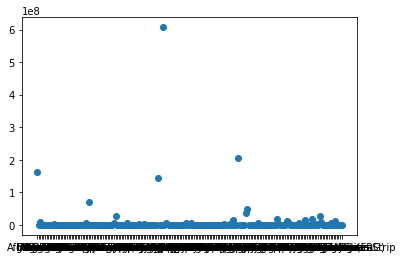

In [21]:
plt.scatter(df_countries_success.index, df_countries_success["Attacks Count"])

In [22]:
df_countries_success.describe()

,success,Attacks Count,Success Percentage,percentage
count,195.000000,1.950000e+02,195.000000,195.000000
mean,828.835897,7.802008e+06,0.049096,4.909567
std,2339.589508,4.857244e+07,0.095433,9.543290
min,0.000000,4.000000e+00,0.000000,0.000000
25%,15.500000,3.425000e+02,0.001726,0.172595
50%,67.000000,6.400000e+03,0.010506,1.050598
75%,354.500000,1.584200e+05,0.043766,4.376560
max,21861.000000,6.069325e+08,0.500000,50.000000


In [27]:
df_countries_success.head()

,success,Attacks Count,Success Percentage,percentage
Country,,,,
Afghanistan,11141,162078361,0.000069,0.006874
Albania,64,6400,0.010000,1.000000
Algeria,2561,7524049,0.000340,0.034038
Angola,486,249001,0.001952,0.195180
Argentina,714,664225,0.001075,0.107494


In [28]:
merged_data = world.merge(df_countries_freq, left_on="SOVEREIGNT", right_on="Country or Area", how="left")
merged_data2 = world.merge(df_countries_success, left_on="SOVEREIGNT", right_on="Country", how="left")
merged_data2.head()


,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,TLC,ADMIN,...,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,geometry,success,Attacks Count,Success Percentage,percentage
0,Admin-0 country,1,6,Fiji,FJI,0,2,Sovereign country,1,Fiji,...,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",16.0,289.0,0.055363,5.536332
1,Admin-0 country,1,3,United Republic of Tanzania,TZA,0,2,Sovereign country,1,United Republic of Tanzania,...,NaN,NaN,NaN,NaN,NaN,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",NaN,NaN,NaN,NaN
2,Admin-0 country,1,7,Western Sahara,SAH,0,2,Indeterminate,1,Western Sahara,...,NaN,Unrecognized,NaN,NaN,NaN,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",5.0,25.0,0.200000,20.000000
3,Admin-0 country,1,2,Canada,CAN,0,2,Sovereign country,1,Canada,...,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",75.0,9216.0,0.008138,0.813802
4,Admin-0 country,1,2,United States of America,US1,1,2,Country,1,United States of America,...,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",NaN,NaN,NaN,NaN


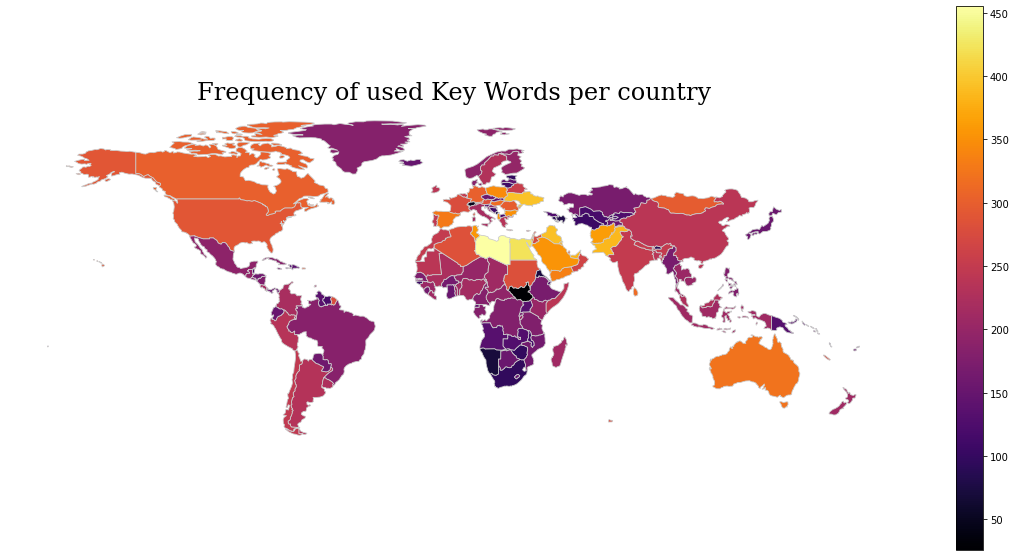

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
merged_data.plot(column="Frequency", cmap="inferno", linewidth=0.8, ax=ax, edgecolor="0.8", legend=True)

# Add title and adjust plot settings as needed
plt.title("Frequency of used Key Words per country", fontsize=24, fontfamily="serif")
ax.axis("off")  # Turn off axis
plt.show()


### Calculating the correlation between the Success Percentage and the Keyword Counter over only Countries (not year)

In [30]:
# Prepare the DataFrames
df_country_keywords.rename_axis(index={'Country or Area': 'Country'}, inplace=True)

# Merge the DataFrames
merged_data = pd.merge(terrorisme_country, df_country_keywords, 
                       left_index=True, right_index=True, how='inner')

# Calculate Correlation
correlation_matrix_country = merged_data[['Success Percentage', 'Keyword Counter']].corr()

# The correlation coefficient between 'Success Percentage' and 'Keyword Counter'
correlation_coefficient_country = correlation_matrix_country.loc['Success Percentage', 'Keyword Counter']

print(f'Correlation Coefficient: {correlation_coefficient_country:.2f}')

Correlation Coefficient: -0.34
